In [1]:
# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the necessary packages
import os, sys
import torch
import torchvision
import time
import cv2

# Add the module path to the sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader


In [3]:
# Import local helper files
from utils.dataset import load

In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available CUDA devices: {num_gpus}")
    
    # Print the name of each GPU
    for i in range(num_gpus):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

# Set the device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Number of available CUDA devices: 1
Device 0: NVIDIA GeForce RTX 3060 Ti


In [5]:
# Specify the shape of the inputs for our network
IMG_SIZE = 120
CROP_SIZE = 110
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [17]:
# Specify the batch size, number of epochs, and the size of the chunks
BATCH_SIZE = 32
NUM_EPOCHS = 4
CHUNK_SIZE = 10000

# Predefined Functions

In [7]:
# Pair Dataset
class FurniturePairDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.data_df = df
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.color_histograms = []
        self.edge_histograms = []
        self._load_images_and_features()

    def _load_images_and_features(self):
        for idx in range(len(self.data_df)):
            try: 
                img_name = os.path.join(self.root_dir, self.data_df.iloc[idx, 0])
                image = Image.open(img_name)
                self.images.append(image)
                self.color_histograms.append(self._extract_color_histogram(image))
                self.edge_histograms.append(self._extract_edge_histogram(image))
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    def _extract_color_histogram(self, image):
        image = np.array(image.convert("RGB"))
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    def _extract_edge_histogram(self, image):
        image = np.array(image.convert("L"))
        edges = cv2.Canny(image, 100, 200)
        hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    def __len__(self):
        return len(self.data_df) * 2  # Each image will appear in one positive and one negative pair

    def __getitem__(self, idx):
        anchor_idx = idx // 2
        anchor_image = self.images[anchor_idx]
        anchor_color_hist = self.color_histograms[anchor_idx]
        anchor_edge_hist = self.edge_histograms[anchor_idx]

        if self.transform:
            anchor_image = self.transform(anchor_image)

        if idx % 2 == 0:
            similar_idx = self._find_most_similar(anchor_idx, anchor_color_hist)
            similar_image = self.images[similar_idx]

            if self.transform:
                similar_image = self.transform(similar_image)

            return (anchor_image, similar_image), 1
        else:
            dissimilar_idx = self._find_most_dissimilar(anchor_idx, anchor_edge_hist)
            dissimilar_image = self.images[dissimilar_idx]

            if self.transform:
                dissimilar_image = self.transform(dissimilar_image)

            return (anchor_image, dissimilar_image), 0

    def _find_most_similar(self, anchor_idx, anchor_hist):
        max_similarity = -1
        similar_idx = -1
        for idx in range(len(self.data_df)):
            if idx == anchor_idx:
                continue
            hist = self.color_histograms[idx]
            similarity = cv2.compareHist(anchor_hist, hist, cv2.HISTCMP_CORREL)
            if similarity > max_similarity:
                max_similarity = similarity
                similar_idx = idx
        return similar_idx

    def _find_most_dissimilar(self, anchor_idx, anchor_hist):
        min_similarity = 1
        dissimilar_idx = -1
        for idx in range(len(self.data_df)):
            if idx == anchor_idx:
                continue
            hist = self.edge_histograms[idx]
            similarity = cv2.compareHist(anchor_hist, hist, cv2.HISTCMP_CORREL)
            if similarity < min_similarity:
                min_similarity = similarity
                dissimilar_idx = idx
        return dissimilar_idx

# Load Dataset

In [8]:
# Path to the dataset
dataPath = '../../Data/Processed_Data/'

In [9]:
# Load DataFrame
furniture_dataset = load(dataPath)

In [10]:
# Check the shape of the dataset
furniture_dataset

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Category,Interior_Style
0,beds\Asian\19726asian-daybeds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
1,beds\Asian\20027asian-canopy-beds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
2,beds\Asian\20109asian-panel-beds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
3,beds\Asian\20508asian-platform-beds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
4,beds\Asian\20750asian-comforters-and-comforter...,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
...,...,...,...,...,...,...,...,...,...,...,...
90078,tables\Victorian\5victorian-side-tables-and-en...,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian
90079,tables\Victorian\6victorian-side-tables-and-en...,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian
90080,tables\Victorian\7victorian-side-tables-and-en...,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian
90081,tables\Victorian\8victorian-dining-tables.jpg,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian


In [11]:
# Transformation logic
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Model Definition

In [12]:
# Define the Siamese Network using PyTorch
class SiameseNetwork(nn.Module):
    def __init__(self, input_shape, embedding_dim=48):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=2, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, embedding_dim)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.global_avg_pool(x)
        x = x.view(-1, 64)
        x = self.fc(x)
        return x

# Euclidean distance layer
class EuclideanDistance(nn.Module):
    def forward(self, featsA, featsB):
        return F.pairwise_distance(featsA, featsB, keepdim=True)

# Define the complete Siamese Network model
class SiameseModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=48):
        super(SiameseModel, self).__init__()
        self.feature_extractor = SiameseNetwork(input_shape, embedding_dim)
        self.euclidean_distance = EuclideanDistance()
        self.fc = nn.Linear(1, 1)

    def forward(self, inputA, inputB):
        featsA = self.feature_extractor(inputA)
        featsB = self.feature_extractor(inputB)
        distance = self.euclidean_distance(featsA, featsB)
        output = torch.sigmoid(self.fc(distance))
        return output

In [13]:
# Initialize model, loss function, and optimizer
model = SiameseModel(IMG_SHAPE).to(DEVICE)

# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

model.apply(initialize_weights)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [14]:
# Function to process a chunk for training
def process_chunk_train(chunk_df, epoch, chunk_idx, num_chunks):
    pair_dataset = FurniturePairDataset(df=chunk_df, root_dir=dataPath, transform=transform)
    pair_dataloader = DataLoader(pair_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    model.train()
    start_time = time.time()
    running_loss = 0.0
    total_batches = len(pair_dataloader)
    print(f"Total samples in this chunk: {len(chunk_df)}")
    print(f"Total batches in this chunk: {total_batches}")
    
    for batch_idx, ((imageA, imageB), labels) in enumerate(pair_dataloader):
        imageA, imageB, labels = imageA.cuda(), imageB.cuda(), labels.float().cuda()
        optimizer.zero_grad()
        outputs = model(imageA, imageB)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        if (batch_idx + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Chunk {chunk_idx + 1}/{num_chunks}, Batch {batch_idx + 1}/{total_batches}, Loss: {running_loss / (batch_idx + 1)}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Chunk {chunk_idx + 1}/{num_chunks} completed in {elapsed_time:.2f} seconds")

    return running_loss / total_batches

In [15]:
# Function to process a chunk for validation
def process_chunk_validate(chunk_df):
    pair_dataset = FurniturePairDataset(df=chunk_df, root_dir=dataPath, transform=transform)
    pair_dataloader = DataLoader(pair_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model.eval()
    running_loss = 0.0
    total_batches = len(pair_dataloader)
    
    with torch.no_grad():
        for batch_idx, ((imageA, imageB), labels) in enumerate(pair_dataloader):
            imageA, imageB, labels = imageA.cuda(), imageB.cuda(), labels.float().cuda()
            outputs = model(imageA, imageB)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_loss += loss.item()
    
    return running_loss / total_batches

In [18]:
# Process the dataset in chunks for training
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    num_chunks = len(furniture_dataset) // CHUNK_SIZE + 1
    total_train_loss = 0.0
    
    for chunk_idx in range(num_chunks):
        chunk_df = furniture_dataset.iloc[chunk_idx * CHUNK_SIZE:(chunk_idx + 1) * CHUNK_SIZE]
        print(f"Processing training chunk {chunk_idx + 1}/{num_chunks}")
        train_loss = process_chunk_train(chunk_df, epoch, chunk_idx, num_chunks)
        total_train_loss += train_loss
    
    avg_train_loss = total_train_loss / num_chunks
    
    # Perform validation on a chunk of the dataset
    validation_chunk_df = furniture_dataset.iloc[:CHUNK_SIZE]  # Use the first chunk for validation
    validation_loss = process_chunk_validate(validation_chunk_df)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss}, Validation Loss: {validation_loss}")
    scheduler.step(validation_loss)  # Update the learning rate scheduler with the validation loss

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Siamese Baseline Model time: {elapsed_time:.2f} seconds")

Processing training chunk 1/10
Total samples in this chunk: 10000
Total batches in this chunk: 625
Epoch 1/4, Chunk 1/10, Batch 50/625, Loss: 0.29167494028806684
Epoch 1/4, Chunk 1/10, Batch 100/625, Loss: 0.24474819451570512
Epoch 1/4, Chunk 1/10, Batch 150/625, Loss: 0.2128835172454516
Epoch 1/4, Chunk 1/10, Batch 200/625, Loss: 0.1900296653434634
Epoch 1/4, Chunk 1/10, Batch 250/625, Loss: 0.17179866386950016
Epoch 1/4, Chunk 1/10, Batch 300/625, Loss: 0.1591136738533775
Epoch 1/4, Chunk 1/10, Batch 350/625, Loss: 0.14746607764491013
Epoch 1/4, Chunk 1/10, Batch 400/625, Loss: 0.13870152513496578
Epoch 1/4, Chunk 1/10, Batch 450/625, Loss: 0.13097097458110915
Epoch 1/4, Chunk 1/10, Batch 500/625, Loss: 0.12392907046154142
Epoch 1/4, Chunk 1/10, Batch 550/625, Loss: 0.11767921916801821
Epoch 1/4, Chunk 1/10, Batch 600/625, Loss: 0.11198785829047363
Epoch 1/4, Chunk 1/10 completed in 253.54 seconds
Processing training chunk 2/10
Total samples in this chunk: 10000
Total batches in this

In [23]:
# Save the model and optimizer state
torch.save(model.state_dict(), 'Siamese.pth')
torch.save(optimizer.state_dict(), 'Optimizer.pth')

print("Model and optimizer state saved.")

Model and optimizer state saved.


In [24]:
import pickle

# Save the transformation pipeline
with open('Transform.pkl', 'wb') as f:
    pickle.dump(transform, f)

print("Transformation pipeline saved.")

Transformation pipeline saved.


In [19]:
testDataPath = "../../Data/Furniture_Data/"
furniture_test_dataset = load(testDataPath)

Error processing ../../Data/Furniture_Data/lamps\Modern\11286modern-lighting.jpg: [Errno 13] Permission denied: '../../Data/Furniture_Data/lamps\\Modern\\11286modern-lighting.jpg'


In [20]:
CHUNK_TEST_SIZE = 100

chunk_df = furniture_test_dataset.iloc[1:CHUNK_TEST_SIZE]

pair_dataset = FurniturePairDataset(df=chunk_df, root_dir=testDataPath, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


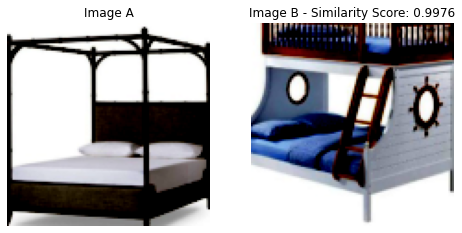

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


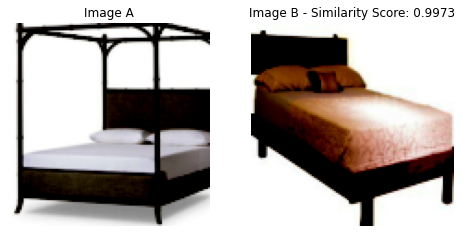

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


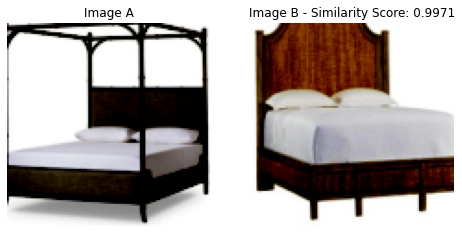

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


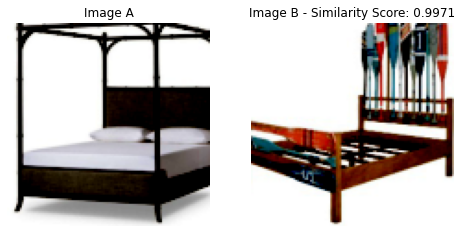

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


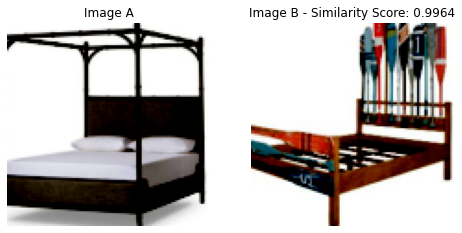

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


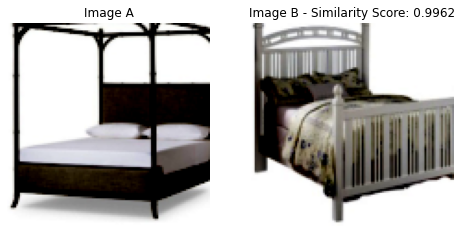

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


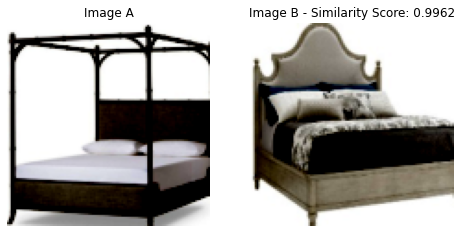

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


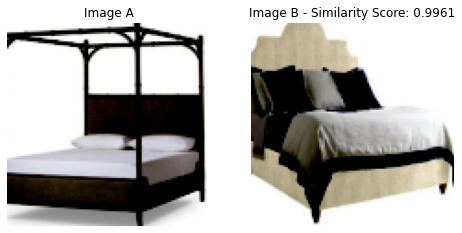

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


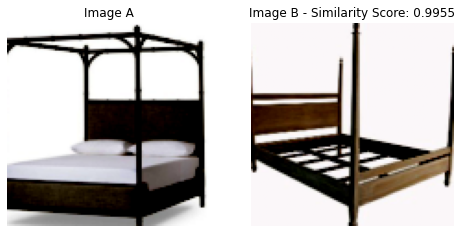

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


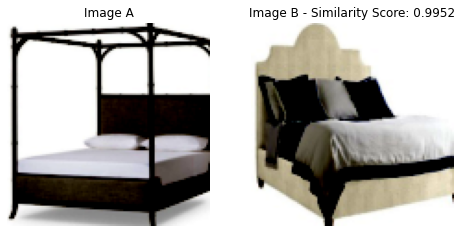

In [22]:
import imagehash

def evaluate_model_with_visualization(model, dataset, transform, device, num_samples=10):
    model.eval()
    similarity_scores = []
    image_pairs = []
    unique_images = set()
    with torch.no_grad():
        for i in range(num_samples):
            # Choose a random sample from the dataset
            sample_idx = np.random.randint(len(dataset))
            image_pair1, label1 = dataset[1]
            image_pair, label = dataset[sample_idx]
            inputA, inputB = image_pair1[0].unsqueeze(0).to(device), image_pair[0].unsqueeze(0).to(device)
            output = model(inputA, inputB)
            
            # Convert tensors to images
            imageA = inputA.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            imageB = inputB.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            
            # Calculate perceptual hashes
            img_hash_A = str(imagehash.phash(Image.fromarray((imageA * 255).astype(np.uint8))))
            img_hash_B = str(imagehash.phash(Image.fromarray((imageB * 255).astype(np.uint8))))
            
            # Check if the images are duplicates
            if img_hash_A not in unique_images and img_hash_B not in unique_images:
                unique_images.add(img_hash_A)
                unique_images.add(img_hash_B)
                similarity_scores.append(output.item())
                image_pairs.append((imageA, imageB))
    
    # Sort the similarity scores and image pairs based on similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1][:10]
    
    # Display the top 10 image pairs with highest similarity scores
    for idx in sorted_indices:
        imageA, imageB = image_pairs[idx]
        score = similarity_scores[idx]
        
        # Display the images along with the predicted similarity score
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(imageA)
        plt.title('Image A')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(imageB)
        plt.title(f'Image B - Similarity Score: {score:.4f}')
        plt.axis('off')

        plt.show()

# Evaluate the trained model with visualization
evaluate_model_with_visualization(model, pair_dataset, transform, DEVICE, num_samples=10000)